This notebook created some data for the DMS model via the REST API.

# Contents
- [Schema and data](#Schema-and-data)
- [Inserting and retrieving](#Inserting-and-retrieving)
- [Wildcards](#Wildcards)
- [Filtering](#Filtering)
- [Visualization](#Visualization)


In [1]:
import requests
from rich.pretty import pprint
from rich import print_json
import json

# location of the DB (B=base URL for MongoDB, DB=database name)
B='http://localhost:8080'
DB='dms0'

# small wrapper for the REST API
def get(p,no_show=False,**kw):
    r=requests.get(f'{B}/{p}',params=kw)
    if not r.ok: raise RuntimeError(r.text)
    data=json.loads(r.text)
    if not no_show: pprint(data)
    return data
def post(p,**kw):
    r=requests.post(f'{B}/{p}',json=kw)
    if not r.ok: raise RuntimeError(r.text)
    return json.loads(r.text)
def patch(p,**kw):
    r=requests.patch(f'{B}/{p}',json=kw)
    if not r.ok: raise RuntimeError(r.text)
    return json.loads(r.text)



# Schema and data

The following dictionary is a `BeamState` which covers all types defined in the schema (and includes multiply-referenced objects).

Note:

* Any attribute can be omitted: won't be saved in the DB and won't be returned
* Numbers are given as
    - `{'value':56.3,'unit':'m'}` for scalars with unit
    - `{'value':[[1,2],[3,4],[5,6]],'unit':'m'}` for arrays with unit
    - `{'value':33}` or `33` for scalars without unit (similar for arrays without unit)
* Numbers are converted to the units specified in the schema (via `astropy.units`), and will be returned with that unit
* Strings are given as plain strings
* Bytes are given as strings (e.g. base64-encoded), and will be returned as such
* Relative links with dot-notation are used to reference previously defined objects (leading dots ascend)

In [3]:
dta={ # BeamState 
    "beam":{ # Beam
        "length": { "value": 2500, "unit":"mm" },
        "height": { "value": 20, "unit":"cm" },
        "density": { "value": 3.5, "unit":"g/cm3" },
        "cs":{ # CrossSection
            "rvePositions": {"value":[[1,2,3],[4,5,6]],"unit":"mm"},
            "rve":{  # ConcreteRVE
                "origin":{"value":[5,5,5],"unit":"mm"},
                "size":{ "value":[150,161,244],"unit":"um" },
                "ct":{ # CTScan
                    "id":"scan-000"
                },
                "materials":[
                    { # MaterialRecord
                        "name":"mat0",
                        "props":{"origin":"CZ","year":2018,"quality":"good"},
                    },
                    { # MaterialRecord
                        "name":"mat1",
                        "props":{"origin":"PL","year":2016,"project":"HTL-344PRP"},
                    }
                ]
            },        
        }
    },
    "cs": ".beam.cs", # relative link to the ../beam/cs object
    "npointz": 2,
    "csState":[
        { # CrossSectionState
            "eps_axial": { "value":344, "unit":"um/m" },
            "bendingMoment": { "value":869, "unit":"kN*m" },
            "rveStates":[ 
                { # ConcreteRVEState
                    "rve":"...beam.cs.rve", # rel 
                    "sigmaHom": { "value": 89.5, "unit":"MPa" }
                },
                { # ConcreteRVEState
                    "rve":"...beam.cs.rve", # rel 
                    "sigmaHom": { "value": 81.4, "unit":"MPa" }
                },
            ]
        },
        { # CrossSectionState
            "eps_axial": { "value":878, "unit":"um/m" },
            "bendingMoment": { "value":123, "unit":"kN*m" },
            "rveStates":[ 
                { # ConcreteRVEState
                    "rve":"...beam.cs.rve", # rel 
                    "sigmaHom": { "value": 55.6, "unit":"MPa" }
                },
            ]
        },

    ],

}


# Inserting and retrieving

* POST will create new object in the database, returning its ID
* GET wil lretrieve the object; in this case, we use
    * `meta=False` to strip metadata so that the result is more human-readable
    * `tracking=True` to use relative references for multiply-returned objects (instead of duplicating them)


In [4]:
ID=post('dms0/BeamState',**dta)
get(f'dms0/BeamState/{ID}',meta=False,tracking=True);

{
│   'beam': {
│   │   'length': {'value': 2.5, 'unit': 'm'},
│   │   'height': {'value': 0.2, 'unit': 'm'},
│   │   'density': {'value': 3499.9999999999995, 'unit': 'kg / m3'},
│   │   'cs': {
│   │   │   'rvePositions': {
│   │   │   │   'value': [
│   │   │   │   │   [0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032],
│   │   │   │   │   [0.004000000189989805, 0.005000000353902578, 0.006000000052154064]
│   │   │   │   ],
│   │   │   │   'unit': 'm'
│   │   │   },
│   │   │   'rve': {
│   │   │   │   'origin': {
│   │   │   │   │   'value': [0.005000000353902578, 0.005000000353902578, 0.005000000353902578],
│   │   │   │   │   'unit': 'm'
│   │   │   │   },
│   │   │   │   'size': {'value': [150.0, 161.0, 244.0], 'unit': 'um'},
│   │   │   │   'ct': {'id': 'scan-000'},
│   │   │   │   'materials': [
│   │   │   │   │   {'name': 'mat0', 'props': {'origin': 'CZ', 'year': 2018, 'quality': 'good'}},
│   │   │   │   │   {'name': 'mat1', 'props': {'origin': 'PL', 'year': 2016, 'project': 'HTL-344PRP'}}
│   │   │   │   ]
│   │   │   }
│   │   }
│   },
│   'cs': '.beam.cs',
│   'npointz': {'value': 2},
│   'csState': [
│   │   {
│   │   │   'eps_axial': {'value': 344.0, 'unit': 'um / m'},
│   │   │   'bendingMoment': {'value': 869.0, 'unit': 'kN m'},
│   │   │   'rveStates': [
│   │   │   │   {'rve': '...beam.cs.rve', 'sigmaHom': {'value': 89.5, 'unit': 'MPa'}},
│   │   │   │   {'rve': '...beam.cs.rve', 'sigmaHom': {'value': 81.4000015258789, 'unit': 'MPa'}}
│   │   │   ]
│   │   },
│   │   {
│   │   │   'eps_axial': {'value': 878.0, 'unit': 'um / m'},
│   │   │   'bendingMoment': {'value': 123.0, 'unit': 'kN m'},
│   │   │   'rveStates': [{'rve': '...beam.cs.rve', 'sigmaHom': {'value': 55.599998474121094, 'unit': 'MPa'}}]
│   │   }
│   ]
}

In [4]:
# the same, but with metadata; max_level limits recursion
get(f'dms0/BeamState/{ID}',tracking=True,max_level=1);

{
│   '_meta': {'id': '63905a715745c632fbe6fa63', 'type': 'BeamState'},
│   'beam': {
│   │   '_meta': {'id': '63905a715745c632fbe6fa5d', 'type': 'Beam', 'parent': '63905a715745c632fbe6fa63'},
│   │   'length': {'value': 2.5, 'unit': 'm'},
│   │   'height': {'value': 0.2, 'unit': 'm'},
│   │   'density': {'value': 3499.9999999999995, 'unit': 'kg / m3'}
│   },
│   'cs': {
│   │   '_meta': {'id': '63905a715745c632fbe6fa5c', 'type': 'CrossSection', 'parent': '63905a715745c632fbe6fa63'},
│   │   'rvePositions': {
│   │   │   'value': [
│   │   │   │   [0.0010000000474974513, 0.0020000000949949026, 0.003000000026077032],
│   │   │   │   [0.004000000189989805, 0.005000000353902578, 0.006000000052154064]
│   │   │   ],
│   │   │   'unit': 'm'
│   │   }
│   },
│   'npointz': {'value': 2},
│   'csState': [
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '63905a715745c632fbe6fa60',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '63905a715745c632fbe6fa63'
│   │   │   },
│   │   │   'eps_axial': {'value': 344.0, 'unit': 'um / m'},
│   │   │   'bendingMoment': {'value': 869.0, 'unit': 'kN m'}
│   │   },
│   │   {
│   │   │   '_meta': {
│   │   │   │   'id': '63905a715745c632fbe6fa62',
│   │   │   │   'type': 'CrossSectionState',
│   │   │   │   'parent': '63905a715745c632fbe6fa63'
│   │   │   },
│   │   │   'eps_axial': {'value': 878.0, 'unit': 'um / m'},
│   │   │   'bendingMoment': {'value': 123.0, 'unit': 'kN m'}
│   │   }
│   ]
}

# Wildcards

In [29]:
## PLAIN INDEX
# no wildcard: this selects csState 0 
get(f'dms0/BeamState/{ID}',path='csState[0]',meta=False,no_show=True);
# no wildcard: this selects last csState
get(f'dms0/BeamState/{ID}',path='csState[-1]',meta=False,no_show=True);

## MULTIINDEX
# multiindex: this selects csState 0 (note the trailing comma)
get(f'dms0/BeamState/{ID}',path='csState[0,]',meta=False,no_show=True);
# multiindex: this selects csStates 0,1,0 (0 is repeated - not very useful)
get(f'dms0/BeamState/{ID}',path='csState[0,1,0]',meta=False,no_show=True);

## SLICE
# selects all csStates
get(f'dms0/BeamState/{ID}',path='csState[:]',meta=False,no_show=True);
# selects all csStates, but backwards
get(f'dms0/BeamState/{ID}',path='csState[::-1]',meta=False,no_show=True);

## COMBINATIONS
# slicing or multiindexing can be used with attribute access:
get(f'dms0/BeamState/{ID}',path='csState[:].eps_axial',meta=False);

# selects all csStates, within all rveStates, within all materials, and returns their names
# as the objects are interlinked, the name will be repeated
get(f'dms0/BeamState/{ID}',path='csState[:].rveStates[:].rve.materials[:].name',meta=False);

[{'value': 344.0, 'unit': 'um / m'}, {'value': 878.0, 'unit': 'um / m'}]

['mat0', 'mat1', 'mat0', 'mat1', 'mat0', 'mat1']

# Filtering

Any wildcard (i.e. multiindex or slice) can be combined with filter, written as `attr[wildcard|filter]`.

In [32]:
# get all csStates which have multiple rveStates
get(f'dms0/BeamState/{ID}',path='csState[:|len(rveStates)>1]',meta=False,no_show=True);
# this can be chained or combined with other filters
get(f'dms0/BeamState/{ID}',path='csState[:|len(rveStates)>1].eps_axial',meta=False,no_show=True);
# filtering nested attributes is possible normally: select where first rveState has sigmaHom>80, then get its eps_axial
get(f'dms0/BeamState/{ID}',path='csState[:|rveStates[0].sigmaHom["value"]>80].eps_axial',meta=False);

[{'value': 344.0, 'unit': 'um / m'}]

# Visualization
The data can be visualized via the `graph` endpoint which returns nodes and edges. This can be used to verify that referenced obejcts were inserted only once and are shared.

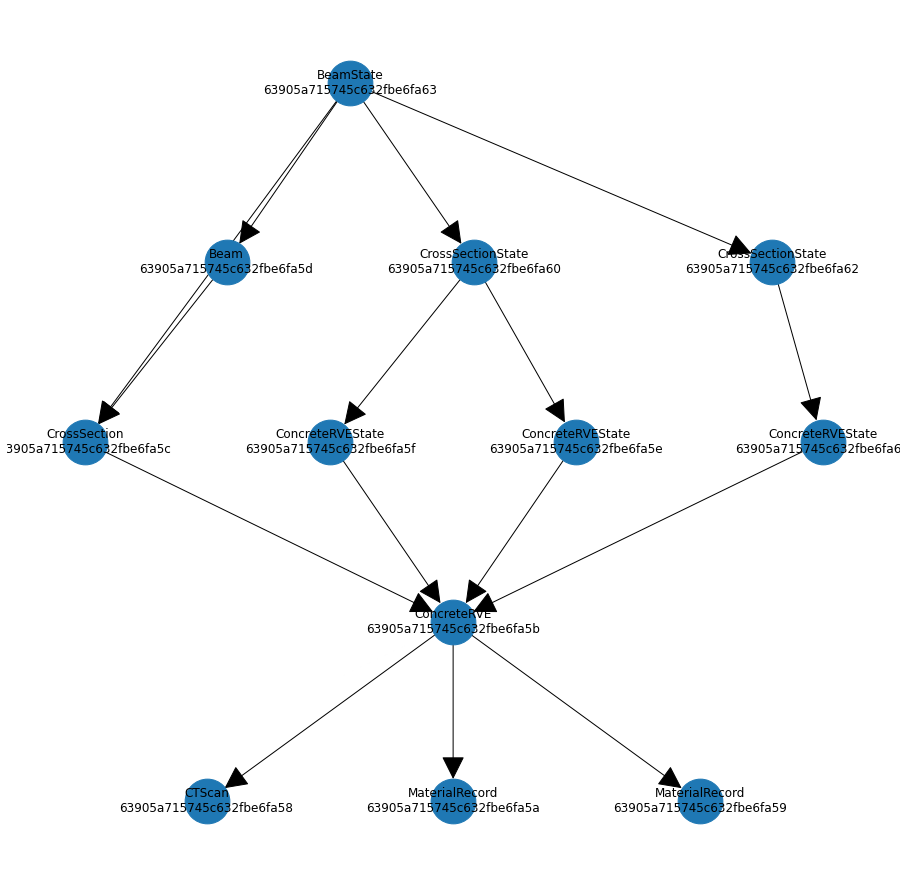

In [5]:
import networkx as nx
from networkx.drawing.nx_pydot import pydot_layout

import matplotlib.pyplot as plt
nodes,edges=get(f'{DB}/BeamState/{ID}/graph',debug=True,no_show=True)
G=nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)
rootNode=nodes[0]
fig,ax=plt.subplots(1,1,figsize=(16,16))
nx.draw(
    G,ax=ax,with_labels=True,
    node_size=2000,
    pos=pydot_layout(G,root=rootNode,prog='dot'),
    arrowsize=50,
)

# Smart clone
We use graph analysis to check which objects need to be deep-copied, given a list of write paths. The graph colors nodes based on whether they should be deep-copied (wiill be modified, or are on the path to modified object) or simply linked.


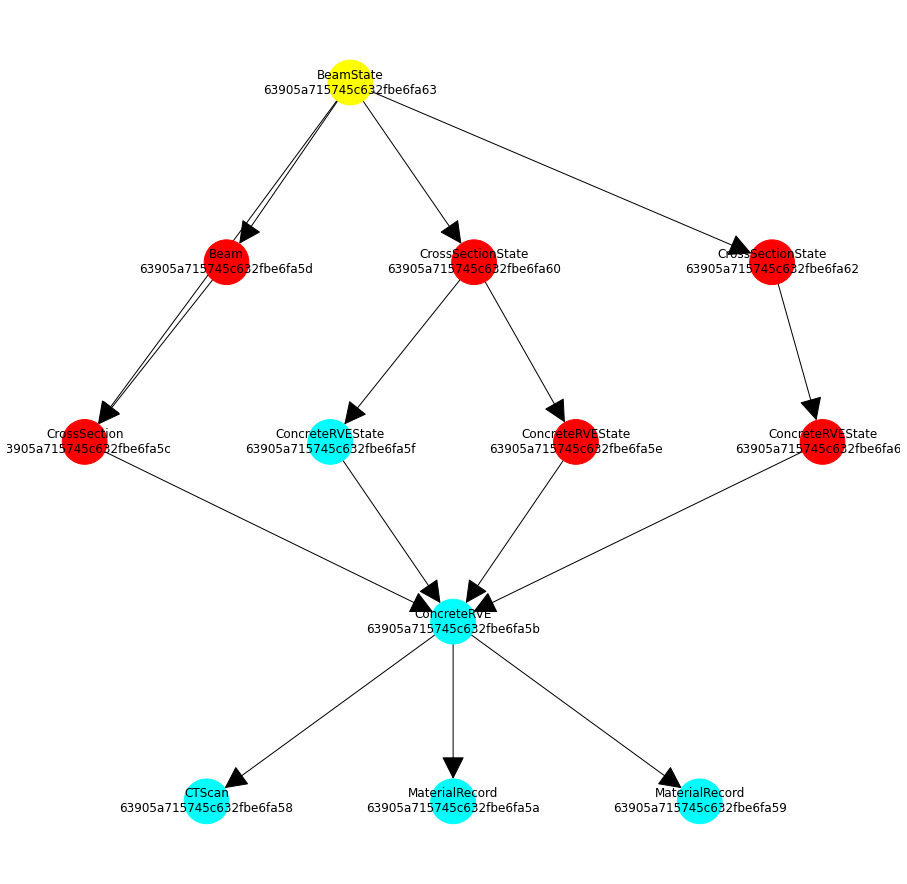

In [6]:
mods='cs.rvePositions csState[0].bendingMoment csState[0].eps_axial csState[0].rveStates[0].sigmaHom csState[1].rveStates[0].epsHom'
#mods='cs.rvePositions'
#mods=''
# get safe links including klass names (for graphing)
safe_debug=get(f'{DB}/BeamState/{ID}/safe-links',paths=mods,debug=True,no_show=True)
safe=get(f'{DB}/BeamState/{ID}/safe-links',paths=mods,no_show=True)

fig,ax=plt.subplots(1,1,figsize=(16,16))

# coloring function
def n_c(n):
    if n.endswith(ID): return 'yellow'
    if n in safe_debug: return 'cyan'
    return 'red'


nx.draw(
    G,ax=ax,with_labels=True,
    node_size=2000,
    pos=pydot_layout(G,root=rootNode,prog='dot'),
    arrowsize=50,
    node_color=[n_c(n) for n in G.nodes],
    
)

IDs of nodes which are safe can be passed to clone, which will only link them (instead of deep-copying). The following graph should be the same, but this time it is colored by database content after clone, by checking nodes which have `upstream` in their metadata (were deep-copied) and which were cloned (no `upstream` in `_meta`).

'63905a745745c632fbe6fa6a'

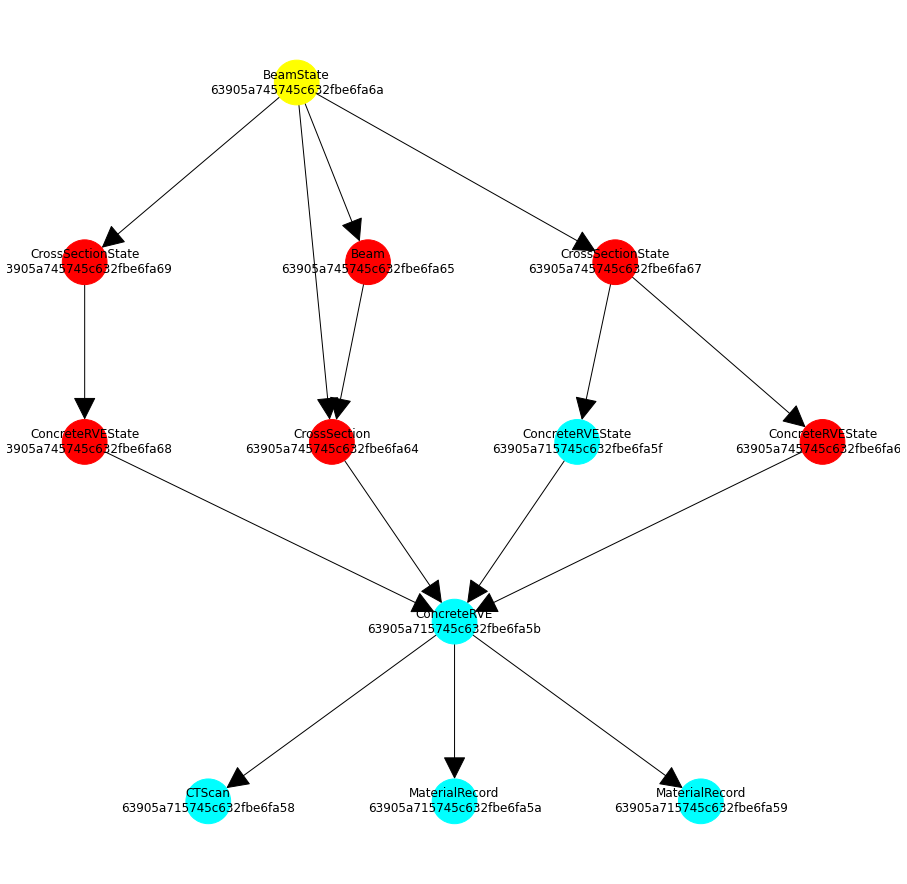

In [7]:
ID2=get(f'{DB}/BeamState/{ID}/clone',shallow=' '.join(safe))

nodes2,edges2=get(f'{DB}/BeamState/{ID2}/graph',debug=True,no_show=True)
G2=nx.DiGraph()
G2.add_nodes_from(nodes2)
G2.add_edges_from(edges2)
fig,ax=plt.subplots(1,1,figsize=(16,16))

# coloring function
def n_c(n):
    type,id=n.split('\n')
    if id==ID2: return 'yellow'
    # ask the DB whether the node has upstream (i.e. was cloned)
    nn=get(f'{DB}/{type}/{id}',max_level=1,no_show=True)
    if 'upstream' in nn['_meta']: return 'red'
    return 'cyan'

nx.draw(
    G2,ax=ax,with_labels=True,
    node_size=2000,
    pos=pydot_layout(G2,root=nodes2[0],prog='dot'),
    arrowsize=50,
    node_color=[n_c(n) for n in G2.nodes]
)
